In [1]:
import numpy as np
import pandas as pd

from econml.metalearners import SLearner, TLearner, XLearner
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import lightgbm as lgb

from sklearn.metrics import mean_absolute_percentage_error

import networkx as nx

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
COLORS = [
    '#FFFFFF',
    '#ECECEC',
    '#EBDF2B',
    '#263F6B',
    '#213559',
]

# A Simple Blueprint to Predict Causal Effects for Unseen Data Using Python

This is a notebook accompanying the blog post **[Level Up! A Simple Blueprint to Predict Causal Effects for Unseen Data Using Python.]()**

**CATE** ($\tau$) is defined as:

$$\Large \tau(X_i) = E[Y_i(1)|X_i] - E[Y_i(0)|X_i]$$

<br>

## Experimental data

Our **SCM** is defined by the following set of structural equations:

$$\large X \sim \mathcal{N}(0, 1)$$

$$\large T \sim Bernoulli(0.5)$$

$$\large y := 2\times T \times f(X) + 2 + \mathcal{N}(0, 1)$$

<br>
where:

* $X$ is a $d$-dimensional feature vector (in our example $d=4$)
* $T$ is the treatment
* $y$ is the outcome

* $f(X)$ is a function defined in the code block below.


In [3]:
G = nx.DiGraph()
G.add_edges_from(
    [
        ('X', 'Y'),
        ('T', 'Y')
    ]
)

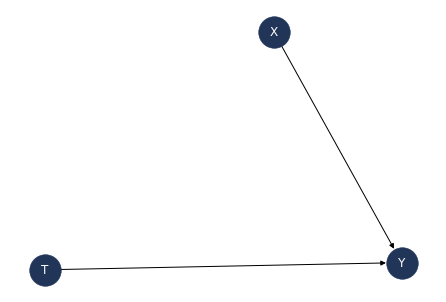

In [4]:
nx.draw(
    G, 
    node_color=COLORS[4],
    node_size=1000,
    font_color=COLORS[0],
    with_labels=True,)

In [28]:
class SCM:
    """An SCM representing the data generating process"""
    def __init__(self, x_dim=1):
        self.x_dim = x_dim
    
    def sample(self, sample_size):
        X = np.random.normal(0, 1, (sample_size, self.x_dim))
        noise_y = np.random.randn(sample_size, 1)
        T = np.random.choice([0., 1.], (sample_size, 1))
        y = T * (2. * self.__get_coefficients(X)).sum(axis=1).reshape(-1, 1) + 2. + noise_y
        return X, T, y, noise_y
    
    def get_counterfactual(self, X, T, noise_y):
        y = T * (2. * self.__get_coefficients(X)).sum(axis=1).reshape(-1, 1) + 2. + noise_y
        return y
        
    def __get_coefficients(self, X):
        return np.sin(X) + X * np.where(X > 0, 2.25, -3.25)

## Get the data

In [29]:
# Initialize the SCM
scm = SCM(x_dim=4)

# Sample from the SCM
X, T, y, noise_y = scm.sample(1000)

## Initialize and fit the models

In [30]:
# Intialize the models
s_learner = SLearner(
    overall_model=lgb.LGBMRegressor(n_estimators=500, max_depth=10)
)

t_learner = TLearner(
    models=[
        lgb.LGBMRegressor(n_estimators=500, max_depth=10),
        lgb.LGBMRegressor(n_estimators=500, max_depth=10)
    ]
)

x_learner = XLearner(
    models=[
        lgb.LGBMRegressor(n_estimators=500, max_depth=10),
        lgb.LGBMRegressor(n_estimators=500, max_depth=10)
    ],
    propensity_model=lgb.LGBMClassifier(n_estimators=500, max_depth=10)
)

In [31]:
# Fit the models
s_learner.fit(X=X, T=T.ravel(), Y=y.ravel())#, inference='bootstrap')
t_learner.fit(X=X, T=T.ravel(), Y=y.ravel())#e='bootstrap')
x_learner.fit(X=X, T=T.ravel(), Y=y.ravel())

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


## Evaluate the models

In [35]:
# Generate the test data
X_test, _, y_test, noise_y_test = scm.sample(10000)

results = []
for i in range(1000):
    data_scm_1 = scm.get_counterfactual(X_test, np.ones(X_test.shape[0]).reshape(-1, 1), noise_y_test)
    data_scm_0 = scm.get_counterfactual(X_test, np.zeros(X_test.shape[0]).reshape(-1, 1), noise_y_test)
    results.append((data_scm_1 - data_scm_0))

In [36]:
# Genertae predictions
preds_s = s_learner.effect(X_test)
preds_t = t_learner.effect(X_test)
preds_x = x_learner.effect(X_test)

# Generate the expected ground truth
y_true_expected = np.array(results).mean(axis=0).ravel()

In [37]:
# Compute MAPE
for model, preds in {'S-Learner': preds_s, 'T-Learner': preds_t, 'X-Learner': preds_x}.items():
    mape = mean_absolute_percentage_error(y_true=y_true_expected, y_pred=preds)
    print(f'{model} MAPE = {mape:0.4f}')

S-Learner MAPE = 0.0895
T-Learner MAPE = 0.0978
X-Learner MAPE = 0.0974


## Confounded observational data

In [897]:
class SCM2:
    """An SCM representing the data generating process"""
    def __init__(self, x_dim=1):
        self.x_dim = x_dim
    
    def sample(self, sample_size, p0=.5):
        self.Z = np.random.uniform(0, 1, (sample_size, 1))
        X = np.random.normal(0, 1, (sample_size, self.x_dim))
        T = np.where(self.Z < p0, 0, 1)#np.random.choice([0., 1.], (sample_size, 1), p=[])
        y = T * (2. * self.__get_coefficients(X)).sum(axis=1).reshape(-1, 1) + self.Z + 1. + np.random.randn(sample_size, 1)
        return X, T, y
    
    def get_counterfactual(self, X, T):
        y = T * (2. * self.__get_coefficients(X)).sum(axis=1).reshape(-1, 1) + self.Z + np.random.randn(X.shape[0], 1)
        return y
        
    def __get_coefficients(self, X):
        return np.sin(X) + X * np.where(X > 0, 2.25, -3.25)

In [946]:
# Initialize the SCM
scm = SCM2(x_dim=4)

# Sample from the SCM
X, T, y = scm.sample(1000, p0=.71)

In [947]:
# Intialize the models
s_learner = SLearner(
    overall_model=lgb.LGBMRegressor(n_estimators=500, max_depth=10)
)

t_learner = TLearner(
    models=[
        lgb.LGBMRegressor(n_estimators=500, max_depth=10),
        lgb.LGBMRegressor(n_estimators=500, max_depth=10)
    ]
)

x_learner = XLearner(
    models=[
        lgb.LGBMRegressor(n_estimators=500, max_depth=10),
        lgb.LGBMRegressor(n_estimators=500, max_depth=10)
    ],
    propensity_model=lgb.LGBMClassifier(n_estimators=500, max_depth=10)
)

In [948]:
# Fit the models
s_learner.fit(X=X, T=T.ravel(), Y=y.ravel())#, inference='bootstrap')
t_learner.fit(X=X, T=T.ravel(), Y=y.ravel())#e='bootstrap')
x_learner.fit(X=X, T=T.ravel(), Y=y.ravel())

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [949]:
# Generate the test data
X_test, _, y_test = scm.sample(100)

results = []
for i in range(1000):
    data_scm_1 = scm.get_counterfactual(X_test, np.ones(X_test.shape[0]).reshape(-1, 1))
    data_scm_0 = scm.get_counterfactual(X_test, np.zeros(X_test.shape[0]).reshape(-1, 1))
    results.append((data_scm_1 - data_scm_0))

In [950]:
# Genertae predictions
preds_s = s_learner.effect(X_test)
preds_t = t_learner.effect(X_test)
preds_x = x_learner.effect(X_test)

# Generate the expected ground truth
y_true_expected = np.array(results).mean(axis=0).ravel()

In [951]:
# Compute MAPE
for model, preds in {'S-Learner': preds_s, 'T-Learner': preds_t, 'X-Learner': preds_x}.items():
    mape = mean_absolute_percentage_error(y_true=y_true_expected, y_pred=preds)
    print(f'{model} MAPE = {mape:0.4f}')

S-Learner MAPE = 0.1155
T-Learner MAPE = 0.1355
X-Learner MAPE = 0.1305


## Hillstrom data

In [759]:
data = pd.read_csv(r'data/hillstrom_clean.csv')

In [760]:
data

,recency,history,mens,womens,newbie,visit,conversion,spend,zip_code__rural,zip_code__surburban,zip_code__urban,channel__multichannel,channel__phone,channel__web,treatment
0,10,142.44,1,0,0,0,0,0.0,0,1,0,0,1,0,"[0, 1, 0]"
1,6,329.08,1,1,1,0,0,0.0,1,0,0,0,0,1,"[1, 0, 0]"
2,7,180.65,0,1,1,0,0,0.0,0,1,0,0,0,1,"[0, 1, 0]"
3,9,675.83,1,0,1,0,0,0.0,1,0,0,0,0,1,"[0, 0, 1]"
4,2,45.34,1,0,0,0,0,0.0,0,0,1,0,0,1,"[0, 1, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,0,0,0,0.0,0,0,1,0,0,1,"[0, 0, 1]"
63996,5,38.91,0,1,1,0,0,0.0,0,0,1,0,1,0,"[0, 0, 1]"
63997,6,29.99,1,0,1,0,0,0.0,0,0,1,0,1,0,"[0, 0, 1]"
63998,1,552.94,1,0,1,0,0,0.0,0,1,0,1,0,0,"[0, 1, 0]"
